## WORKFLOW SHOWCASAE
______________________________________________________________________

### 0.1. READ SAFELY THE DATA SOURCE

In [1]:
import configparser

# initiate the config parser
config = configparser.ConfigParser()

# read the config.ini file
config.read('config.ini')

# access the file path
xlsx_file_path = config['path']['nflx_exercise']

### 0.2. DEFINE HTML DISPLAY

In [2]:
from IPython.display import display, HTML
import pandas as pd

# Define the CSS that will make the table scrollable
css = """
.output {
    max-height: 500px; /* Adjust as needed */
    overflow: scroll;  /* Allows scrolling */
}
"""

# Apply the CSS for scrollable output
display(HTML('<style>{}</style>'.format(css)))

# Configure pandas display options for better visuals
pd.set_option('display.max_rows', None)  # Display all rows, adjust as needed
pd.set_option('display.max_columns', None)  # Display all columns, adjust as needed
pd.set_option('display.max_colwidth', 90)  # Set max column width for long text
pd.options.display.float_format = '{:,.2f}'.format  # Format floating-point numbers

______________
### 1. DATA EXPOSURE

In [3]:
# Read the Excel file and clean the specified fields
nflx_top_ten = pd.read_excel(xlsx_file_path, sheet_name='NFLX Top 10')
nflx_top_ten['show_title'] = nflx_top_ten['show_title'].str.strip()
nflx_top_ten['season_title'] = nflx_top_ten['season_title'].fillna('unavailable')

imdb_rating = pd.read_excel(xlsx_file_path, sheet_name='IMDB Rating')
imdb_rating['title'] = imdb_rating['title'].str.strip()
imdb_rating['title'] = imdb_rating['title'].fillna('unavailable')

runtime = pd.read_excel(xlsx_file_path, sheet_name='Runtime')
runtime['title'] = runtime['title'].str.strip()
runtime['title'] = runtime['title'].fillna('unavailable')

# Function to display DataFrame overview and table
def display_overview(df, title):
    # Get summary statistics and shape
    summary_stats = df.describe().to_html()
    shape_info = f"<div><b>Shape:</b> {df.shape}</div>"
    
    # Display the title, shape, summary statistics, and table
    display(HTML(f"<h2>{title}</h2>"))
    display(HTML(shape_info))
    display(HTML(f"<div><b>Summary Statistics:</b></div>"))
    display(HTML(summary_stats))


# Function to display table
def display_table(df, title):
    shape_info = f"<div><b>shape:</b>{df.shape}</div>"

# Display title and table
    display(HTML(f"<h2>{title}</h2>"))
    display(HTML(shape_info))
    display(HTML (f"<div<b>Complete Dataset<b></div>"))
    display(HTML(df.to_html(index=False)))

In [4]:
# Display overview and table for each DataFrame
display_overview(imdb_rating, "IMDB RATING OVERVIEW")

In [5]:
# Display overview and table for each DataFrame
display_overview(runtime, "RUNTIME OVERVIEW")

In [6]:
# Display overview and table for each DataFrame
display_overview(nflx_top_ten, "NFLX TOP 10 OVERVIEW")

**NFLX Top 10** - List of weekly Netflix rankings for each category.

- **date_added**: The date YipitData scraped the information from the Netflix website.
- **week**: The week of the ranking. The date represents the last day of the week.
- **category**: Category classification for each title. The available categories are: Films (English), Films (Non-English), TV (English), and TV (Non-English).
- **show_title**: The title of the show or film.
- **season_title**: The season of the show (if applicable).
- **weekly_rank**: The rank of the title for the associated week, split by category (each category has a top 10).
- **cumulative_weeks_in_top_10**: The number of total weeks (not necessarily consecutive) a title has spent in the top 10.
- **weekly_hours_viewed**: The total number of hours Netflix users spent watching the title in the week.


#### **IMPORTANT! THERE WAS A SYSTEM OUTAGE DURING THE WEEK OF MAY 22,2022**

### OUTAGE DATA

In [15]:
# Pre-step: Filter the DataFrame for the outage week (2022-05-22)
outage_week_date = pd.to_datetime('2022-05-22')
outage = nflx_top_ten[nflx_top_ten['week'] == outage_week_date]

# Calculate summary statistics by category for the specified columns
summary_stats = outage.groupby('category').agg({
    'weekly_rank': ['count', 'mean'],
    'weekly_hours_viewed': ['count', 'mean']
}).reset_index()

# Flatten the multi-level columns for better readability
summary_stats.columns = [''.join(col).strip() for col in summary_stats.columns.values]

# Display the summary statistics in a basic HTML table format
display(HTML(summary_stats.to_html(index=False)))

# Display the filtered version of the outage week
display_table(outage, "")

/var/folders/30/600l0m910w15x4zqk261vx_c0000gn/T/ipykernel_31068/930627812.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = outage.groupby('category').agg({


______________
### 2. DATA PREPARE
#### 2.1. NETFLIX TOP 10 DATA

In [16]:
# Step 1: Declare data types
nflx_top_ten = nflx_top_ten.astype({
    'date_added': 'datetime64[ns]',
    'week': 'datetime64[ns]',
    'category': 'category',
    'show_title': 'string',
    'season_title': 'string',
    'weekly_rank': 'int64',
    'cumulative_weeks_in_top_10': 'int64',
    'weekly_hours_viewed': 'float64'
})

# Step 2: Filter the outage week
outage_week = pd.to_datetime('2022-05-22')
nflx_filtered = nflx_top_ten[nflx_top_ten['week'] != outage_week]

display_overview(nflx_filtered, "FILTERED NFLX TOP 10")
display_table(nflx_filtered, "")

#### 2.2. IMDB RATING

In [17]:
# Store the initial shape of the dataset
initial_shape = imdb_rating.shape

# Step 1: Remove rows where 'title' is 'null' or 'unavailable'
# Create a mask to identify rows to remove
mask = imdb_rating['title'].isin(['null', 'unavailable'])
# Count the number of rows to be removed
removed_rows_step1 = mask.sum()
# Remove the rows
imdb_rating_cleaned = imdb_rating[~mask]

# Step 2: Identify and remove duplicate rows based on 'title' and 'rating'
# Count the number of duplicate rows
duplicate_rows = imdb_rating_cleaned.duplicated(subset=['title', 'rating'], keep=False)
removed_rows_step2 = duplicate_rows.sum()
# Remove duplicate rows
imdb_rating_cleaned = imdb_rating_cleaned[~duplicate_rows]

# Step 3: Sort by 'title' and 'rating', then drop duplicates preserving the greatest rating
# Sort the DataFrame
imdb_rating_cleaned = imdb_rating_cleaned.sort_values(by=['title', 'rating'], ascending=[True, False])
# Drop duplicates, keeping the first occurrence (which has the highest rating due to sorting)
imdb_rating_final = imdb_rating_cleaned.drop_duplicates(subset=['title'], keep='first',)
imdb_rating_final = imdb_rating_final.sort_values(by='rating',ascending=False).reset_index(drop=True)
# Count the number of rows removed in this step
removed_rows_step3 = len(imdb_rating_cleaned) - len(imdb_rating_final)

# Display informative message for Steps 1, 2 and 3
display(HTML(f"<div><b>Step 1:</b> Removed {removed_rows_step1} rows where 'title' is 'null' or 'unavailable'.</div>"))
display(HTML(f"<div><b>Step 2:</b> Removed {removed_rows_step2} duplicate rows based on 'title' and 'rating'.</div>"))
display(HTML(f"<div><b>Step 3:</b> Removed {removed_rows_step3} rows after sorting and dropping duplicates, preserving the greatest rating.</div>"))

# Store the final shape of the dataset
final_shape = imdb_rating_final.shape

# Display the final cleaned DataFrame
display(HTML("<h3>Final Cleaned DataFrame:</h3>"))

# Display the before and after shape as a subtitle
display(HTML(f"<h4>Initial Shape: {initial_shape} | Final Shape: {final_shape}</h4>"))

display(imdb_rating_final)

title  \
0                                                                                       Khawatir   
1                                                                                Planet Earth II   
2                                                                                   Planet Earth   
3                                                                                   Breaking Bad   
4                                                                     Avatar: The Last Airbender   
5                                                                       The Shawshank Redemption   
6                                                                                 Blue Planet II   
7                                                                                     Our Planet   
8                                                                                 Rick and Morty   
9                                                                                Irmão do Jorel   
10                                                                                      The Hunt   
11                                                                            Because I Love You   
12                                                                                    Reply 1988   
13                                                                                 The Godfather   
14                                                                                      3ABtalks   
15                                                                                The Last Dance   
16                                                                              Leyla and Mecnun   
17                                                                                     My Mister   
18                                                                                  Kota Factory   
19                                                                                        Arcane   
20                                                                               Yeh Meri Family   
21                                                                                          Life   
22                                                              Fullmetal Alchemist: Brotherhood   
23                                                                               The Vietnam War   
24                                                                   Hans Zimmer: Live in Prague   
25                                                                                      Sherlock   
26                                                                                No Longer kids   
27                                                                         Nature's Great Events   
28                                                                               Attack on Titan   
29                                                                    Attack on Titan OAD Series   
30                                                                                    DEATH NOTE   
31                                                                                        Okupas   
32                                                    Leah Remini: Scientology and the Aftermath   
33                                                                               The Dark Knight   
34                                                                Raja, Rasoi aur Anya Kahaniyan   
35                                                                                      Humsafar   
36                                                                                       The War   
37                                                                        Hunter X Hunter (2011)   
38                                                      David Attenborough: A Life on Our Planet   
39                                                           The Twilight Zone (Original Se

______________
### 3. DATA MANIPULATION TO ANSWER THE QUESTIONS

#### 3.1. THE MOST APPEARED ENGLISH FILM AND ITS VIEWERSHIP

In [11]:
# Step 1: Filter the dataset to show only 'Films (English)'
film_english = nflx_filtered[nflx_filtered['category'] == 'Films (English)']

# Step 2: Create a summary table for English films
summary_table = film_english.groupby('show_title').agg(
    Appearances=('show_title', 'size'),  # Count of appearances
    Avg_Weekly_Hours_Viewed=('weekly_hours_viewed', 'mean')  # Average of weekly_hours_viewed
).reset_index()

# Step 3: Sort by 'Appearances' in descending order
summary_table = summary_table.sort_values(by='Appearances', ascending=False).reset_index(drop=True)


# Step 5: Display the shape and summary table 
display(HTML(f"<div><b>Shape of English Films Only:</b> {film_english.shape}</div>"))
display(HTML("<h3>Summary Table for English Films:</h3>"))
display(summary_table)

show_title  Appearances  \
0                                  Sonic the Hedgehog            7   
1                                         Senior Year            5   
2                                    The Adam Project            5   
3                                      The In Between            4   
4                                   A Perfect Pairing            4   
5                                         How It Ends            4   
6                                  365 Days: This Day            3   
7                                              Hustle            3   
8                                         Interceptor            3   
9                                               Shrek            3   
10            Chickenhare and the Hamster of Darkness            3   
11                                         Spiderhead            2   
12                                         Our Father            2   
13                                          Marmaduke            2   
14                             The Amazing Spider-Man            2   
15                                        Jackass 4.5            2   
16                                     The Blind Side            2   
17                                         The Bubble            2   
18                                    Silverton Siege            2   
19                                Shrek Forever After            2   
20                                    Return to Space            2   
21                        Men in Black: International            2   
22                                           365 Days            2   
23                                           Halftime            2   
24                                          The Vault            2   
25                                      U.S. Marshals            2   
26                                 Along for the Ride            2   
27                                      Choose or Die            2   
28                                          Collision            2   
29                                            Cleaner            2   
30   The Mystery of Marilyn Monroe: The Unheard Tapes            2   
31                                        The Outpost            1   
32                                            Top Gun            1   
33                                      The Gentlemen            1   
34                                     Trees of Peace            1   
35         Trust No One: The Hunt for the Crypto King            1   
36                                           The Mist            1   
37                                             Sing 2            1   
38                                              Turbo            1   
39                               The Man from Toronto            1   
40  White Hot: The Rise & Fall of Abercrombie & Fitch            1   
41                                           The Call            1   
42                                        Metal Lords            1   
43                                    Rescued by Ruby            1   
44                                  Rambo: Last Blood            1   
45                                      6 Underground            1   
46                                   A Dog's Way Home            1   
47                                  A Score to Settle            1   
48                                        Ben Is Back            1   
49                                  Blade Runner 2049            1   
50                                Cleveland Abduction            1   
51                                          Dangerous            1   
52                                        Deep Impact            1   
53                                     Den of Thieves            1   
54                      Disappearance at Clifton Hill            1   
55                                             Enough            1   
56                                        Escape Room

#### 3.2. THE ENGLISH FILMS WITH THE LOWEST IMDb RATING

In [171]:
# Step 1: Get rows from 'imdb_rating_final' where 'rating' is 0
zero_rating_rows = imdb_rating_final[imdb_rating_final['rating'] == 0]

# Display the rows with a rating of 0
display(HTML(f"<div><b>Step 1:</b> Filter rows with a rating of 0 in IMDb:</div>"))

# Step 2: Filter 'summary_table' to only include shared values with the titles from Step 1
if not zero_rating_rows.empty:
    zero_rating_titles = zero_rating_rows['title'].tolist()
    filtered_summary_table = summary_table[summary_table['show_title'].isin(zero_rating_titles)]
    
    # Display the shape of 'summary_table' before and after filtering
    display(HTML(f"<div><b>Step 2:</b> Shape of 'summary_table' before filtering: {summary_table.shape}</div>"))
    display(HTML(f"<div><b>Step 2:</b> Shape of 'summary_table' after filtering: {filtered_summary_table.shape}</div>"))
    
    # Step 3: Display the complete filtered summary table
    display(HTML("<h3>Filtered Summary Table:</h3>"))
    display(filtered_summary_table)
else:
    display(HTML("<div><b>Step 2:</b> No rows with a rating of 0 found. Skipping filtering.</div>"))

show_title  Appearances  \
2                             The Adam Project            5   
8                                  Interceptor            3   
10     Chickenhare and the Hamster of Darkness            3   
20                             Return to Space            2   
35  Trust No One: The Hunt for the Crypto King            1   
43                             Rescued by Ruby            1   
44                           Rambo: Last Blood            1   
61                               Love & Gelato            1   
64                         Operation Mincemeat            1   

    Avg_Weekly_Hours_Viewed  
2             10,206,000.00  
8             29,803,333.33  
10            14,843,333.33  
20             5,850,000.00  
35            12,070,000.00  
43             6,380,000.00  
44             6,530,000.00  
61            25,790,000.00  
64            12,620,000.00

#### 3.3 THE ENGLISH FILMS WITH THE MOST WEEKS IN THE TOP TEN

In [175]:
# Step 1: Filter the dataset to show only 'Films (English)'
film_english = nflx_filtered[nflx_filtered['category'] == 'Films (English)']
print(film_english.shape)

# Step 2: Select only 'show_title' and 'cumulative_weeks_in_top_10'
film_english = film_english[['show_title', 'cumulative_weeks_in_top_10']]

# Step 3: Sort and drop duplicates to leave the largest value for 'cumulative_weeks_in_top_10' on top
film_english = film_english.sort_values(by='cumulative_weeks_in_top_10', ascending=False)
film_english = film_english.drop_duplicates(subset='show_title', keep='first')

# Display the outcome using IPython HTML display
display(HTML(f"<div>English Films that stayed in the top 10 for the largest amount of weeks (Excluding Outage Data): {film_english.shape} </div>"))
display(film_english)

(120, 8)


show_title  \
366                                 Sonic the Hedgehog   
372                                   The Adam Project   
302                                              Shrek   
274                                        Senior Year   
9                                    A Perfect Pairing   
460                                        How It Ends   
387                                     The In Between   
0                                               Hustle   
146                                        Jackass 4.5   
425                                         Gemini Man   
472                                      6 Underground   
280                                          The Vault   
517            Chickenhare and the Hamster of Darkness   
347                                    Rescued by Ruby   
294                                 365 Days: This Day   
35                                         Interceptor   
396                                         Our Father   
382                                           Halftime   
339                                Shrek Forever After   
367                                          Marmaduke   
251                        Men in Black: International   
250                                 Along for the Ride   
424                                      U.S. Marshals   
358                                    Return to Space   
270                                          Collision   
93                                           Dangerous   
516                                         The Bubble   
54                              The Amazing Spider-Man   
63                                             Cleaner   
66                                            365 Days   
490                                         Spiderhead   
92                                       Choose or Die   
162   The Mystery of Marilyn Monroe: The Unheard Tapes   
154                                     The Blind Side   
169                                    Silverton Siege   
474                                             Sing 2   
355                                           The Call   
443  White Hot: The Rise & Fall of Abercrombie & Fitch   
421                                     Den of Thieves   
417                                  Rambo: Last Blood   
409         Trust No One: The Hunt for the Crypto King   
486                                      The Gentlemen   
397                                        Escape Room   
462               Mission: Impossible - Ghost Protocol   
351                                  Playing with Fire   
216                                        Ben Is Back   
166                                        Deep Impact   
164                                Operation Mincemeat   
141                                     Trees of Peace   
129                                           The Mist   
126                                   A Dog's Way Home   
89                                     Yakuza Princess   
75                                       Four Brothers   
70                       Disappearance at Clifton Hill   
28                                              Enough   
3                                 The Man from Toronto   
344                                  A Score to Settle   
341                                       Jack Reacher   
340                                      Love & Gelato   
332                                        The Outpost   
310                                Cleveland Abduction   
305                                                 It   
258                                            Top Gun   
256                                  Blade Runner 2049   
247                                              Turbo   
238                                        Metal Lords   
518                                Memoirs of a Geisha   

     cumulative_weeks_in_top_10  
366                           8  
372                           8

In [12]:
# Step 1: Filter the dataset to show only 'Films (English)'
film_english2 = nflx_top_ten[nflx_top_ten['category'] == 'Films (English)']
print(film_english2.shape)

# Step 2: Select only 'show_title' and 'cumulative_weeks_in_top_10'
film_english2 = film_english2[['show_title', 'cumulative_weeks_in_top_10']]

# Step 3: Sort and drop duplicates to leave the largest value for 'cumulative_weeks_in_top_10' on top
film_english2 = film_english2.sort_values(by='cumulative_weeks_in_top_10', ascending=False)
film_english2 = film_english2.drop_duplicates(subset='show_title', keep='first')

# Display the outcome using IPython HTML display
display(HTML(f"<div>English Films that stayed in the top 10 for the largest amount of weeks (Including Outage Data): {film_english2.shape} </div>"))
display(film_english2)

(130, 8)


show_title  \
366                                 Sonic the Hedgehog   
372                                   The Adam Project   
302                                              Shrek   
274                                        Senior Year   
9                                    A Perfect Pairing   
460                                        How It Ends   
387                                     The In Between   
402                                 365 Days: This Day   
0                                               Hustle   
425                                         Gemini Man   
253                                          Marmaduke   
146                                        Jackass 4.5   
396                                         Our Father   
347                                    Rescued by Ruby   
280                                          The Vault   
472                                      6 Underground   
517            Chickenhare and the Hamster of Darkness   
35                                         Interceptor   
339                                Shrek Forever After   
382                                           Halftime   
66                                            365 Days   
270                                          Collision   
251                        Men in Black: International   
63                                             Cleaner   
54                              The Amazing Spider-Man   
250                                 Along for the Ride   
154                                     The Blind Side   
162   The Mystery of Marilyn Monroe: The Unheard Tapes   
364                                Operation Mincemeat   
169                                    Silverton Siege   
358                                    Return to Space   
516                                         The Bubble   
490                                         Spiderhead   
93                                           Dangerous   
92                                       Choose or Die   
424                                      U.S. Marshals   
397                                        Escape Room   
370                                            Borrego   
462               Mission: Impossible - Ghost Protocol   
417                                  Rambo: Last Blood   
421                                     Den of Thieves   
486                                      The Gentlemen   
443  White Hot: The Rise & Fall of Abercrombie & Fitch   
474                                             Sing 2   
409         Trust No One: The Hunt for the Crypto King   
355                                           The Call   
351                                  Playing with Fire   
166                                        Deep Impact   
141                                     Trees of Peace   
129                                           The Mist   
126                                   A Dog's Way Home   
89                                     Yakuza Princess   
75                                       Four Brothers   
70                       Disappearance at Clifton Hill   
28                                              Enough   
3                                 The Man from Toronto   
216                                        Ben Is Back   
344                                  A Score to Settle   
341                                       Jack Reacher   
340                                      Love & Gelato   
332                                        The Outpost   
310                                Cleveland Abduction   
305                                                 It   
238                                        Metal Lords   
258                                            Top Gun   
256                                  Blade Runner 2049   
247                                              Turbo   
518                                Memoirs of a Geisha   

     cumulative_weeks_in_top_10  
366    

______________
### 4. DATA VISIUALIZATION 

#### 4.1. VIEWERSHIP OVER TIME

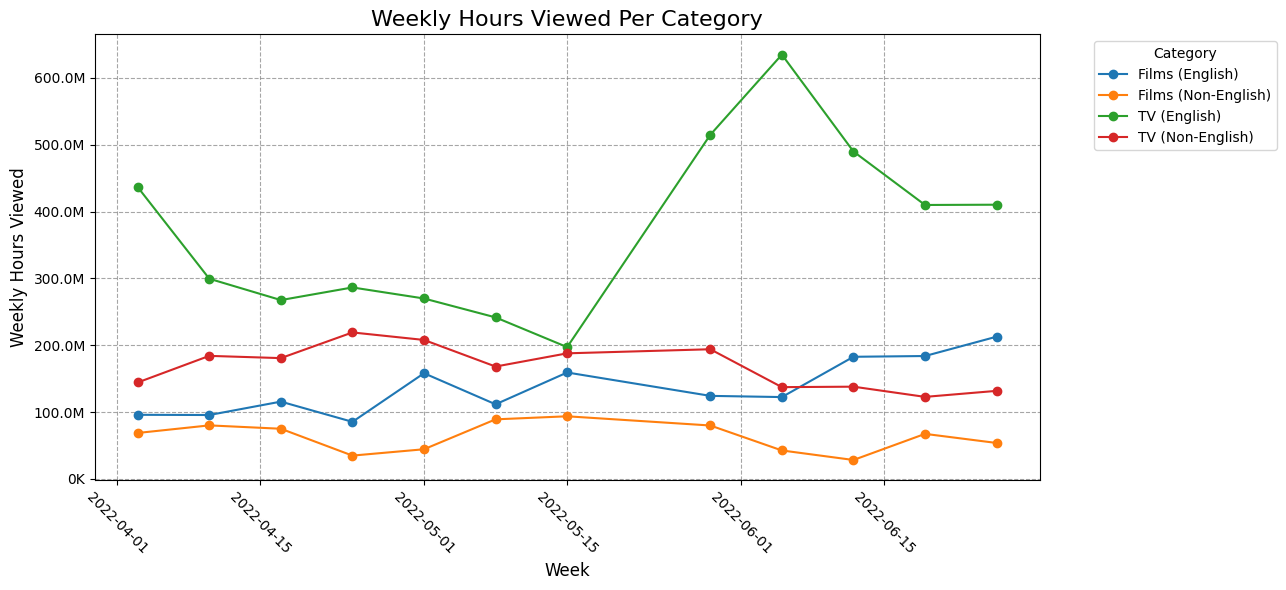

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Aggregate data to handle duplicates, with observed=True to silence FutureWarning
aggregated_data = nflx_filtered.groupby(['week', 'category'], observed=True)['weekly_hours_viewed'].sum().reset_index()

# Pivot the data to have 'week' as x-axis and 'category' as separate lines
pivot_data = aggregated_data.pivot(index='week', columns='category', values='weekly_hours_viewed')

# Plotting
plt.figure(figsize=(13, 6))
colors = plt.cm.tab10.colors  # Different colors for each category

for i, category in enumerate(pivot_data.columns):
    plt.plot(pivot_data.index, pivot_data[category], marker='o', color=colors[i], label=category)

# Formatting
plt.title('Weekly Hours Viewed Per Category', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Weekly Hours Viewed', fontsize=12)

# Format y-axis labels as 'millions' or 'thousands'
formatter = mticker.FuncFormatter(lambda x, pos: f'{x / 1e6:.1f}M' if x >= 1e6 else f'{x / 1e3:.0f}K')
plt.gca().yaxis.set_major_formatter(formatter)

plt.xticks(rotation=-45)  # Rotate x-axis labels to the left for better readability
plt.grid(color='gray', linestyle='--', alpha=0.7)  # Add a gray grid
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')  # Add legend outside the plot

plt.tight_layout()  # Adjust layout for better spacing
plt.show()